# Create shapefiles

Merge LSOAs to create shapefiles for:
* IVT catchment areas
* Ambulance trusts

## 1 Import libraries and set file paths

In [1]:
from dataclasses import dataclass
import geopandas as gpd
import os
import pandas as pd

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data = './data'
    collated = 'collated_data_amb.csv'

    shapefiles = 'shapefiles'
    ivt_catchment = 'ivt_catchment.shp'
    amb_catchment = 'amb_catchment.shp'
    lsoa_shp = ('Lower_layer_super_output_areas_(E+W)_2011_Boundaries_' +
                '(Generalised_Clipped)_V2.zip')


paths = Paths()

## 2 Load data

### 2.1 Load data with closest IVT and ambulance trust per LSOA

In [3]:
df_lsoa = pd.read_csv(os.path.join(paths.data, paths.collated))
df_lsoa.head()

LSOA  admissions closest_ivt_unit  closest_ivt_unit_time  \
0  Welwyn Hatfield 010F    0.666667           SG14AB                   18.7   
1  Welwyn Hatfield 012A    4.000000           SG14AB                   19.8   
2  Welwyn Hatfield 002F    2.000000           SG14AB                   18.7   
3  Welwyn Hatfield 002E    0.666667           SG14AB                   18.7   
4  Welwyn Hatfield 010A    3.333333           SG14AB                   18.7   

  closest_mt_unit  closest_mt_unit_time closest_mt_transfer  \
0          NW12BU                  36.9              CB20QQ   
1          NW12BU                  36.9              CB20QQ   
2          NW12BU                  38.0              CB20QQ   
3          NW12BU                  36.9              CB20QQ   
4          NW12BU                  36.9              CB20QQ   

   closest_mt_transfer_time  total_mt_time  ivt_rate  ...  age_band_males_65  \
0                      39.1           57.8       6.8  ...                 33   
1                      39.1           58.9       6.8  ...                 24   
2                      39.1           57.8       6.8  ...                 33   
3                      39.1           57.8       6.8  ...                 24   
4                      39.1           57.8       6.8  ...                 33   

  age_band_males_70  age_band_males_75  age_band_males_80  age_band_males_85  \
0                28                 26                 14                  5   
1                18                 21                 12                  5   
2                28                  7                  5                  9   
3                17                 15                 16                  9   
4                28                 28                 13                 10   

   age_band_males_90  ambulance_service  local_authority_district_22  \
0                  3    East of England              Welwyn Hatfield   
1                  4    East of England              Welwyn Hatfield   
2                  2    East of England              Welwyn Hatfield   
3                  1    East of England              Welwyn Hatfield   
4                  3    East of England              Welwyn Hatfield   

           LAD22NM  country  
0  Welwyn Hatfield  England  
1  Welwyn Hatfield  England  
2  Welwyn Hatfield  England  
3  Welwyn Hatfield  England  
4  Welwyn Hatfield  England  

[5 rows x 115 columns]

### 2.2 Load LSOA shape file

The following will load the shape file of the England and Wales LSOA (Lower Super Output Areas) into a GeoPandas DataFrame. Note that we can set the crs (Coordinate Reference System) when loading a GeoPandas DataFrame. EPSG:27700 is the crs to use when geography is in BNG (British National Grid Eastings and Northings).

Other crs to consider for other data projections:
* EPSG:27700 OSGB 1936 / British National Grid -- United Kingdom Ordnance Survey. Co-ordinates are in Eastings (X) and Northings (Y).
* EPSG:4326 WGS 84 -- WGS84 - World Geodetic System 1984. Co-ordinates are in Longitude (X) and Latitude (Y).
* EPSG:3857 - projection for displaying lat/long as a flat map

In [4]:
gdf_lsoa = gpd.read_file(os.path.join(
    paths.data, paths.shapefiles, paths.lsoa_shp),
    crs='EPSG:27700')
gdf_lsoa.head()

LSOA11CD                   LSOA11NM                  LSOA11NMW  \
0  E01000001        City of London 001A        City of London 001A   
1  E01000002        City of London 001B        City of London 001B   
2  E01000003        City of London 001C        City of London 001C   
3  E01000005        City of London 001E        City of London 001E   
4  E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   

                                            geometry  
0  POLYGON ((532105.092 182011.230, 532162.491 18...  
1  POLYGON ((532746.813 181786.891, 532671.688 18...  
2  POLYGON ((532135.145 182198.119, 532158.250 18...  
3  POLYGON ((533807.946 180767.770, 533649.063 18...  
4  POLYGON ((545122.049 184314.931, 545271.917 18...

View a simple map of this data.

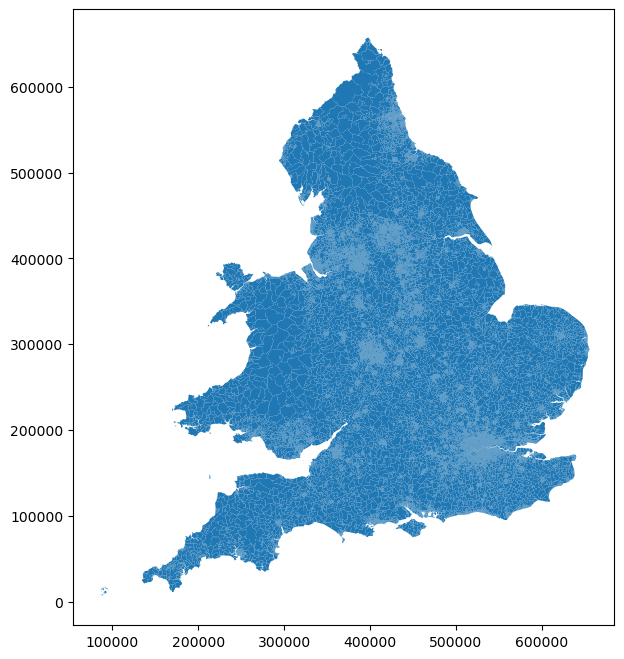

In [5]:
gdf_lsoa.plot(figsize=(8,8));

## 3 Merge LSOAs together to create shapefiles

### 3.1 Define function for creating shapefiles

The method used is explained with the example of creating a shapefile of IVT catchment areas:
1. **Add column to geopandas dataframe** - using LSOA as common value, add field 'closest_ivt_unit'. Match gdf_lsoa['LSOA11NMW'] with df_lsoa['LSOA'] and add df_lsoa['closest_ivt_unit'] to gdf_lsoa['closest_ivt_unit'] - [see here for stackoverflow explanation](https://stackoverflow.com/questions/39816671/pandas-populate-new-dataframe-column-based-on-matching-columns-in-another-datafr)
2. **Ensure no inner lines from original polygons** using buffer(0.0001) - [see here for stackoverflow explanation](https://stackoverflow.com/questions/59797292/deleting-inner-lines-of-polygons-after-dissolving-in-geopandas)
3. **Merge LSOA polygons that are in same IVT unit catchment area** using dissolve() - [see here for geopandas tutorial on aggregation with dissolve](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html)

In [6]:
def create_shapefile(col, file_path, gdf=gdf_lsoa, df=df_lsoa):
    '''
    Merges LSOAs together based on specified column to create a shapefile
    Inputs:
    - col - string, column to group LSOAs based on
    - file_path - string, file path to save shapefile to
    - gdf - geopandas dataframe, created from LSOA shapefile
    - df - dataframe, information for each LSOA
    '''
    # Add column to geopandas LSOA dataframe
    gdf = gdf.merge(
        df[[col, 'LSOA']], left_on='LSOA11NM', right_on='LSOA', how='left')
    gdf = gdf.drop('LSOA', axis=1)

    # Shortern column to first 10 characters (since that's what it will be
    # renamed to for the shapefile) (else get warning message)
    shp_col = col[:10]
    gdf = gdf.rename(columns={col: shp_col})

    # Ensure no inner lines (from the original polygons)
    gdf['geometry'] = gdf['geometry'].buffer(0.0001)

    # Now merge LSOA on specified column
    gdf_catchment = gdf.dissolve(by=shp_col)

    # Save to shapefile
    gdf_catchment.to_file(file_path)

    # Show save location
    display(f'Saved to {file_path}')

    # Display head of dataframe
    display(gdf_catchment.head())

    # Plot shapefile
    gdf_catchment.plot(figsize=(8,8));

### 3.2 Create IVT catchment shapefile

'Saved to ./data/shapefiles/ivt_catchment.shp'

geometry   LSOA11CD  \
closest_iv                                                                 
B152TH      MULTIPOLYGON (((403011.723 266679.152, 402597....  E01008881   
B714HJ      MULTIPOLYGON (((395950.714 272162.470, 395950....  E01008899   
BA13NG      POLYGON ((354665.594 144552.500, 354665.594 14...  E01014370   
BA214AT     MULTIPOLYGON (((330365.588 98427.209, 330281.9...  E01019886   
BB23HH      POLYGON ((369965.000 416593.000, 370071.000 41...  E01004803   

                                     LSOA11NM  \
closest_iv                                      
B152TH                        Birmingham 067A   
B714HJ                        Birmingham 037A   
BA13NG      Bath and North East Somerset 007A   
BA214AT                       East Devon 005A   
BB23HH                            Bolton 001B   

                                    LSOA11NMW  
closest_iv                                     
B152TH                        Birmingham 067A  
B714HJ                        Birmingham 037A  
BA13NG      Bath and North East Somerset 007A  
BA214AT                       East Devon 005A  
BB23HH                            Bolton 001B

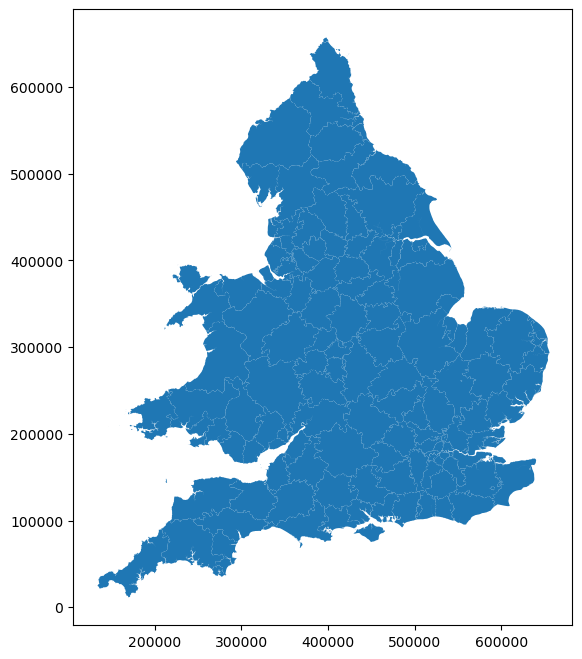

In [7]:
create_shapefile(
    'closest_ivt_unit',
    os.path.join(paths.data, paths.shapefiles, paths.ivt_catchment))

### 3.3 Create ambulance trust shapefile

'Saved to ./data/shapefiles/amb_catchment.shp'

geometry   LSOA11CD  \
ambulance_                                                                      
East Midlands    MULTIPOLYGON (((433631.972 296489.554, 433631....  E01013128   
East of England  MULTIPOLYGON (((503939.688 193345.500, 503939....  E01015589   
Isle of Wight    MULTIPOLYGON (((451071.500 75523.100, 451071.5...  E01017282   
London           MULTIPOLYGON (((510971.125 170480.219, 510971....  E01000001   
North East       MULTIPOLYGON (((418029.261 516224.682, 418029....  E01008162   

                                     LSOA11NM                     LSOA11NMW  
ambulance_                                                                   
East Midlands    North East Lincolnshire 010A  North East Lincolnshire 010A  
East of England             Peterborough 004A             Peterborough 004A  
Isle of Wight              Isle of Wight 006A            Isle of Wight 006A  
London                    City of London 001A           City of London 001A  
North East                     Gateshead 027A                Gateshead 027A

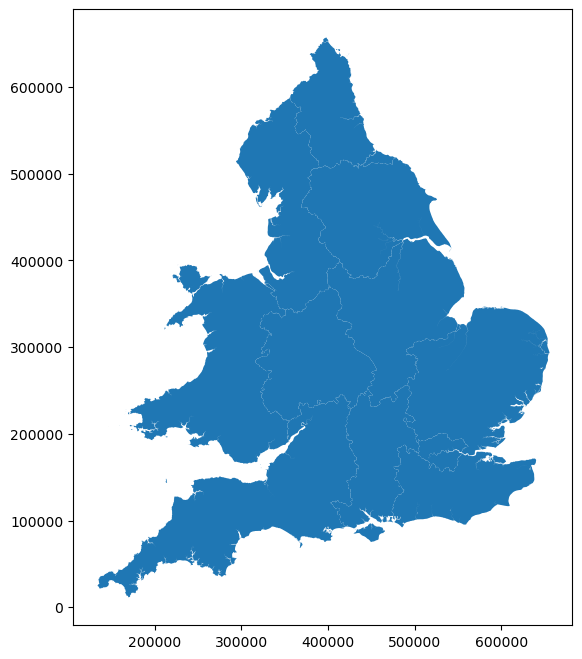

In [8]:
create_shapefile(
    'ambulance_service',
    os.path.join(paths.data, paths.shapefiles, paths.amb_catchment))